# **Modeling and prediction -  SalePrice**

## Objectives

* Engineer features for Classification, Regression and Cluster models

## Inputs

* outputs/datasets/collection/HousePriceRecord.csv
* Pipeline transformers that ca be found in PriceSaleStudy, DataCleaning and Feature Engineering

## Outputs

* Train set (features and target)
* Test set (features and target)
* ML pipeline to predict PriceSale
* labels map
*Feature Importance Plot

## Conclusions

...


---

# Change working directory


* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heriting-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heriting-housing-issues'

---

# Load Data

We drop WoodDeckSF

In [4]:
import numpy as np
import pandas as pd
df1 = (pd.read_csv("outputs/datasets/collection/HousePriceRecord.csv").drop(labels=['WoodDeckSF'], axis=1))

print(df1.shape)
df1.head(3)

(1460, 23)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500


# ML Pipeline with all data

## ML Pipeline for Modelling and Hyperparameter Optimisation

The below pipeline transformer are taken from the PriceSaleStudy, Datacleaning and Feature Engineering analysis.

In [5]:
from sklearn.pipeline import Pipeline

# Data Cleaning
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer

# Feature Engineering
from feature_engine.encoding import OrdinalEncoder
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt

# Feat Scaling
from sklearn.preprocessing import StandardScaler

# Feat Selection
from sklearn.feature_selection import SelectFromModel

# ML algorithms
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor

def PipelineOptimization(model):
    pipeline_base = Pipeline([

        ( 'arbitrary_number_zero',  ArbitraryNumberImputer(arbitrary_number=0,
                                                    variables=['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea']) ),

        ( 'median',  MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage']) ),

        ( 'categorical_imputer', CategoricalImputer(imputation_method='frequent', variables=['BsmtFinType1', 'GarageFinish']) ),

        ( 'ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary', variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']) ),

        ( 'yeo_johnson', vt.YeoJohnsonTransformer(variables = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'YearRemodAdd', 'GrLivArea',
                                                                'OverallQual', 'OpenPorchSF', 'LotArea', 'YearBuilt', 'MasVnrArea', 'LotFrontage']) ),
                                                                
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ("feat_selection",  SelectFromModel(model)),

        ("model", model),

    ])

    return pipeline_base

The below function is a custom function taken from Code Institute walkthrough project #2. It runs GridSearchCV trough the pipeline and creates a table to show the performance of each transformer in a table.

In [6]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")
            model = PipelineOptimization(self.models[key])

            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring)
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns], self.grid_searches

## Split the dataset

we drop the feature PriceSale as it is the target.

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df1.drop(['SalePrice'], axis=1),
    df1['SalePrice'],
    test_size=0.2,
    random_state=0
)

print("* Train set:", X_train.shape, y_train.shape,
      "\n* Test set:",  X_test.shape, y_test.shape)

* Train set: (1168, 22) (1168,) 
* Test set: (292, 22) (292,)


## Apply the ML for Data Cleaning on the datasets

In [8]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

NameError: name 'PipelineDataCleaningAndFeatureEngineering' is not defined

In [10]:
X_train.head()

,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearRemodAdd
618,-0.0,2.840049,0,6.231707,0,1774,0.0,285.045723,0,0,9.874667,17.923317,3.049801,4.880037,5,6.484417,1822,2.086377e+129
870,-0.0,1.917971,1,0.000000,0,894,0.0,133.391173,0,1,9.241645,14.220455,-0.000000,0.000000,5,3.922905,894,8.495955e+128
92,-0.0,1.917971,1,15.082414,1,163,0.0,176.329005,0,1,10.022651,16.765758,-0.000000,0.000000,7,3.922905,876,2.045585e+129
817,-0.0,2.840049,1,17.584777,2,350,0.0,309.970775,1,0,10.014716,15.409265,2.789425,4.237583,5,5.868985,1568,1.890051e+129
302,-0.0,2.840049,1,0.000000,0,1541,0.0,305.798023,1,0,10.050922,20.871015,2.793018,4.572940,5,5.238591,1541,1.890051e+129


## Target Imbalance

As mention in the SalePriceStudy, Target Imbalance handling is not required in this ML since the SalePrice is well distributed.

## Grid Search CV

We initially run Grid Search CV to find the optimal regressor with the default hyperparameter.

In [9]:
models_quick_search = {
    'LinearRegression': LinearRegression(),
    "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
    "RandomForestRegressor": RandomForestRegressor(random_state=0),
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
    "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
    "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
    "XGBRegressor": XGBRegressor(random_state=0),
}

params_quick_search = {
    'LinearRegression': {},
    "DecisionTreeRegressor": {},
    "RandomForestRegressor": {},
    "ExtraTreesRegressor": {},
    "AdaBoostRegressor": {},
    "GradientBoostingRegressor": {},
    "XGBRegressor": {},
}

In [10]:

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for LinearRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for DecisionTreeRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for RandomForestRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for AdaBoostRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for GradientBoostingRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou


Running GridSearchCV for XGBRegressor 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou

In [11]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,ExtraTreesRegressor,0.707091,0.762671,0.800332,0.030645
5,GradientBoostingRegressor,0.64266,0.761599,0.845895,0.067664
2,RandomForestRegressor,0.618586,0.751698,0.815419,0.068831
0,LinearRegression,0.653162,0.74011,0.835487,0.059205
6,XGBRegressor,0.637822,0.70255,0.81969,0.06405
4,AdaBoostRegressor,0.656483,0.698049,0.742785,0.037059
1,DecisionTreeRegressor,0.352005,0.563148,0.681845,0.112503


**The result shows that ExtraTreesRegressor is the best transformer for our database with a mean score of 0.76.** 

## Hyperparameter optimization


In [12]:
models_quick_search = {
    "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
}

params_search = {
    "ExtraTreesRegressor":{'model__n_estimators': [100,50,150],
                          'model__max_depth': [None, 3, 15],
                          'model__min_samples_split': [2, 50],
                          'model__min_samples_leaf': [1,50],
                            }
  }

In [13]:
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_search)
search.fit(X_train, y_train, scoring='r2', n_jobs=-1, cv=5)


Running GridSearchCV for ExtraTreesRegressor 

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encou

We can extract the best model and best parameters from the grid_search_summary

In [14]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__min_samples_leaf,model__min_samples_split,model__n_estimators
26,ExtraTreesRegressor,0.702092,0.765565,0.79893,0.033203,15,1,2,150
24,ExtraTreesRegressor,0.695566,0.765066,0.797245,0.035717,15,1,2,100
25,ExtraTreesRegressor,0.685567,0.764392,0.798423,0.040402,15,1,2,50
2,ExtraTreesRegressor,0.707397,0.763426,0.799678,0.03055,None,1,2,150
3,ExtraTreesRegressor,0.714062,0.762715,0.799289,0.035095,None,1,50,100
27,ExtraTreesRegressor,0.714092,0.762705,0.799289,0.035071,15,1,50,100
0,ExtraTreesRegressor,0.707091,0.762671,0.800332,0.030645,None,1,2,100
29,ExtraTreesRegressor,0.71419,0.762663,0.800494,0.0357,15,1,50,150
5,ExtraTreesRegressor,0.714205,0.762625,0.800552,0.035739,None,1,50,150
4,ExtraTreesRegressor,0.711978,0.761128,0.796159,0.033848,None,1,50,50


In [15]:
best_model = grid_search_summary.iloc[0,0]
best_model

'ExtraTreesRegressor'

In [16]:
best_parameters = grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': 15,
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 150}

We define the best pipeline

In [17]:
best_pipeline = grid_search_pipelines[best_model].best_estimator_
best_pipeline

Pipeline(steps=[('arbitrary_number_zero',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF', 'EnclosedPorch',
                                                   'MasVnrArea'])),
                ('median',
                 MeanMedianImputer(variables=['BedroomAbvGr', 'GarageYrBlt',
                                              'LotFrontage'])),
                ('categorical_imputer',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtFinType1',
                                               'GarageFinish'])),
                ('ordinal_enc...
                                                  'YearBuilt', 'MasVnrArea',
                                                  'LotFrontage'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('feat_scaling', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesRegressor(random_state=0))),
                ('model',
                 ExtraTreesRegressor(max_depth=15, n_estimators=150,
                                     random_state=0))])

## Assess feature importance

In [18]:
X_train.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd
618,1828,0.0,NaN,Av,48,NaN,1774,NaN,774,Unf,...,Gd,11694,90.0,452.0,108,5,9,1822,2007,2007
870,894,0.0,2.0,No,0,Unf,894,NaN,308,NaN,...,TA,6600,60.0,0.0,0,5,5,894,1962,1962
92,964,0.0,2.0,No,713,ALQ,163,NaN,432,Unf,...,TA,13360,80.0,0.0,0,7,5,876,1921,2006


* These are the 4 most important features in descending order. The model was trained on them: 
['OverallQual', 'TotalBsmtSF', 'GarageArea', 'YearRemodAdd']


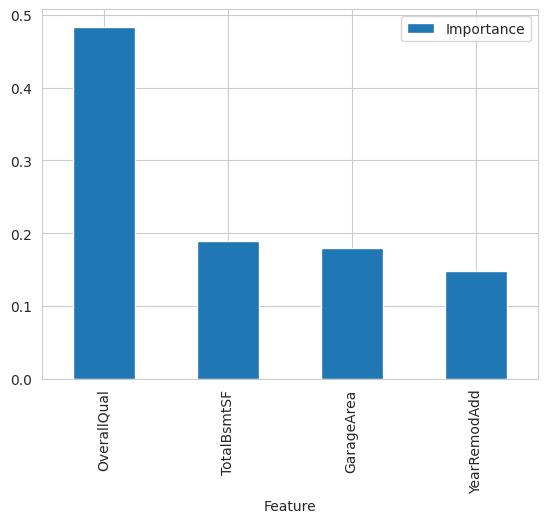

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# after data cleaning and feature engineering, the features may have changes
# how many data cleaning and feature engineering steps does your pipeline have?
data_cleaning_feat_eng_steps = 6
columns_after_data_cleaning_feat_eng = (Pipeline(best_pipeline.steps[:data_cleaning_feat_eng_steps])
                                        .transform(X_train)
                                        .columns)

best_features = columns_after_data_cleaning_feat_eng[best_pipeline['feat_selection'].get_support(
)].to_list()

# create DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': columns_after_data_cleaning_feat_eng[best_pipeline['feat_selection'].get_support()],
    'Importance': best_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()

## Evaluate Regressor Pipeline on Train and Test Sets

The below function is taken from Code Institute Walkthough project #2. It run the a pipeline on both Train and Test set and print the results in 2 tables and plot prediction compare to actual for both set.

In [20]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test, pipeline):
    print("Model Evaluation \n")
    print("* Train Set")
    regression_evaluation(X_train, y_train, pipeline)
    print("* Test Set")
    regression_evaluation(X_test, y_test, pipeline)


def regression_evaluation(X, y, pipeline):
    prediction = pipeline.predict(X)
    print('R2 Score:', r2_score(y, prediction).round(3))
    print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))
    print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))
    print('Root Mean Squared Error:', np.sqrt(
        mean_squared_error(y, prediction)).round(3))
    print("\n")


def regression_evaluation_plots(X_train, y_train, X_test, y_test, pipeline, alpha_scatter=0.5):
    pred_train = pipeline.predict(X_train)
    pred_test = pipeline.predict(X_test)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    sns.scatterplot(x=y_train, y=pred_train, alpha=alpha_scatter, ax=axes[0])
    sns.lineplot(x=y_train, y=y_train, color='red', ax=axes[0])
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predictions")
    axes[0].set_title("Train Set")

    sns.scatterplot(x=y_test, y=pred_test, alpha=alpha_scatter, ax=axes[1])
    sns.lineplot(x=y_test, y=y_test, color='red', ax=axes[1])
    axes[1].set_xlabel("Actual")
    axes[1].set_ylabel("Predictions")
    axes[1].set_title("Test Set")

    plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.995
Mean Absolute Error: 3247.693
Mean Squared Error: 31196941.086
Root Mean Squared Error: 5585.422


* Test Set
R2 Score: 0.745
Mean Absolute Error: 26032.356
Mean Squared Error: 1761065364.449
Root Mean Squared Error: 41965.049




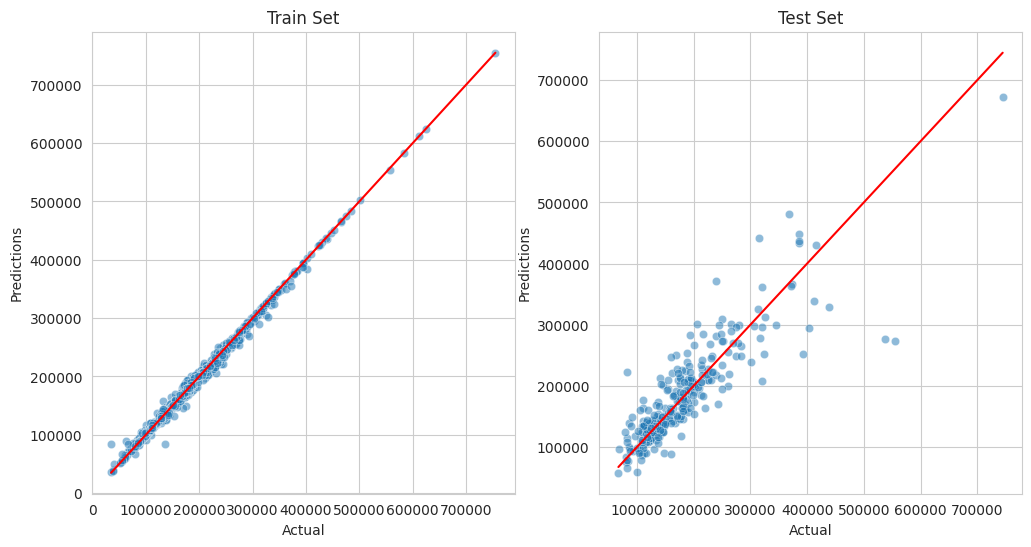

In [21]:
regression_performance(X_train, y_train, X_test, y_test, best_pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, best_pipeline)

## Refit pipeline with best features

In [ ]:
def PipelineOptimization(model):
    pipeline_base = Pipeline([

        # ( 'arbitrary_number_zero',  ArbitraryNumberImputer(arbitrary_number=0,
        #                                             variables=['2ndFlrSF', 'EnclosedPorch', 'MasVnrArea']) ),

        # ( 'median',  MeanMedianImputer(imputation_method='median', variables=['BedroomAbvGr' , 'GarageYrBlt', 'LotFrontage']) ),

        # ( 'categorical_imputer', CategoricalImputer(imputation_method='frequent', variables=['BsmtFinType1', 'GarageFinish']) ),

        # ( 'ordinal_encoder', OrdinalEncoder(encoding_method='arbitrary', variables = ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']) ),

        ( 'yeo_johnson', vt.YeoJohnsonTransformer(variables = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'YearRemodAdd', 'GrLivArea',
                                                                'OverallQual', 'OpenPorchSF', 'LotArea', 'YearBuilt', 'MasVnrArea', 'LotFrontage']) ),
                                                                
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None, method="spearman", threshold=0.6, selection_method="variance")),

        ("feat_scaling", StandardScaler()),

        ('feat_selection',
                 SelectFromModel(estimator=ExtraTreesClassifier(random_state=0))),
        ('model',
                 ExtraTreesClassifier(n_estimators=20, random_state=0)),

    ])

    return pipeline_base

---

# Conclusions

The list below shows the transformations needed for feature engineering for each feature.


Feature Engineering Transformers:

Ordinal categorical encoding: ['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']

Yeo Johnson: ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr', 'BsmtFinSF1', 'GarageArea', 'YearRemodAdd', 'GrLivArea', 'OverallQual', 'OpenPorchSF', 'LotArea', 'YearBuilt', 'MasVnrArea', 'LotFrontage']

Smart Correlation Selection: ['1stFlrSF', 'GarageArea', 'GarageYrBlt', 'GrLivArea', 'YearBuilt']

Those steps will be added in the ML Pipeline